
##### Developer Information
**Full Name:** Chandrika Patibandla  
**University Code:** 700777118

#####  Overview  
This project aims to build and evaluate deep learning models to classify chest X-ray images for COVID-19 detection. The goal is to compare baseline architectures and explore improvements through custom CNN designs for enhanced diagnostic performance, assisting healthcare professionals in early diagnosis and reducing the transmission of the virus.

##### Tasks
- **Task 1:**  
  - Re-implement and evaluate the following baseline models:  
    - A basic Convolutional Neural Network (CNN)  
    - MobileNet  
    - VGG16  
- **Task 2:**  
  - Develop a custom CNN model with deeper architecture.  
  - Add more convolutional layers along with max pooling and dropout layers to improve model performance . 

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix

import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import VGG19, MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import json

#### Paths of dataset:
Dataset has three folders, Train, Test and validation 

In [ ]:
# PATHS
TRAIN_FOLDER = r"Dataset\train"
VAL_FOLDER = r"Dataset\val"
TEST_FOLDER = r"Dataset\test"

### LOAD IMAGES 
Load the images using *ImageDataGenerator* with the class mode set to 'binary'. If the dataset is from the training folder, apply both augmentation and rescaling; otherwise, apply only rescaling.

In [11]:
def load_images(train=True, target_size=(224,224), batch_size=16, class_mode='binary', folder=TRAIN_FOLDER):
    # Parameters
    # ----------
    # train : bool
    #     True for training dataset, False for test dataset
    # target_size : tuple
    #     Size to which the images will be resized which is 224x224 for model
    # batch_size : int
    #     Number of images in each batch
    # class_mode : str
    #     Mode for the target data

    if train:
        # train dataset using ImageDataGenerator for augmentation + rescaling
        datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
    else:
        # test dataset without augmentation and just rescaling
        datagen = ImageDataGenerator(rescale = 1./255)
        
    folder = folder
    _generator = datagen.flow_from_directory(folder, target_size = target_size, batch_size = batch_size, class_mode = class_mode, shuffle=train)
    return _generator

Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Number of images in train dataset:  288
Number of images in test dataset:  60
Number of classes in train dataset: 
 {'NORMAL': 0, 'PNEUMONIA': 1}
Number of classes in test dataset: 
 {'NORMAL': 0, 'PNEUMONIA': 1}


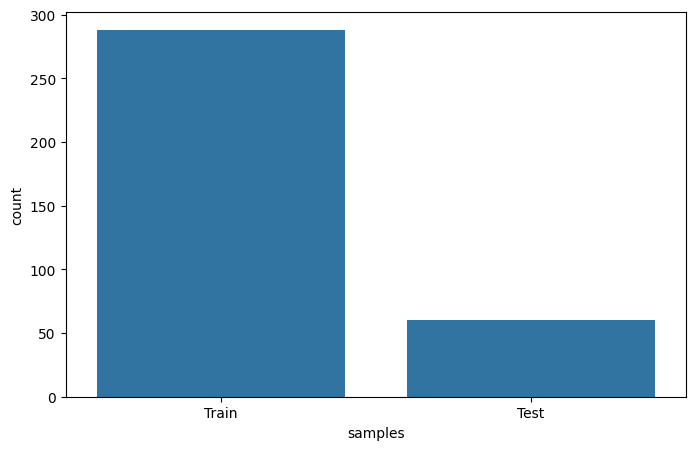

In [59]:
# loading training and test dataset
train_generator = load_images(train=True, folder=TRAIN_FOLDER)
test_generator = load_images(train=False, folder=TEST_FOLDER)

# printing number of images in training and test dataset
print("Number of images in train dataset: ", train_generator.samples)
print("Number of images in test dataset: ", test_generator.samples)
# number of classes in training and test dataset
print("Number of classes in train dataset: \n", train_generator.class_indices)
print("Number of classes in test dataset: \n", test_generator.class_indices)

# plot a distribution of images in training and test dataset
train_df = pd.DataFrame({'samples': ['Train'] * train_generator.samples})
test_df = pd.DataFrame({'samples': ['Test'] * test_generator.samples})

# Combine the DataFrames
combined_df = pd.concat([train_df, test_df])

# Plot the countplot
plt.figure(figsize=(8, 5))
sns.countplot(x="samples", data=combined_df)
plt.show()

### SAMPLE TRAIN AND TEST IMAGES

Display random images from the training and testing sets of the dataset folder.

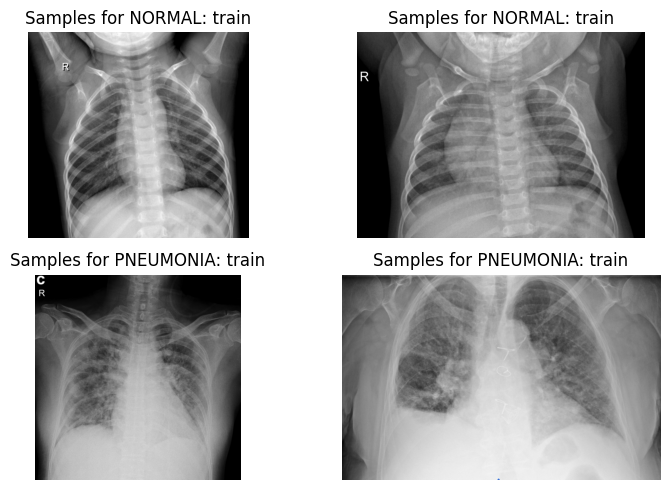

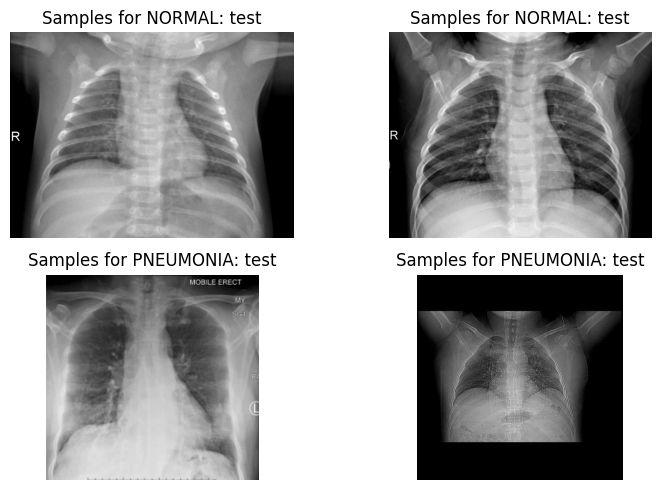

In [13]:
def view_samples(folder="train"):
    plt.figure(figsize=(8, 5))
    for class_index, subfolder in enumerate(train_generator.class_indices.keys()):
        if folder == "train":
            folder_path = os.path.join(TRAIN_FOLDER, subfolder)
        else:
            folder_path = os.path.join(TEST_FOLDER, subfolder)
        files = os.listdir(folder_path)
        random_indices = np.random.choice(len(files), 2, replace=False)
        for i, idx in enumerate(random_indices):
            img_path = os.path.join(folder_path, files[idx])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Fix OpenCV color
            plt.subplot(2, 2, class_index * 2 + i + 1)
            plt.imshow(img)
            plt.title(f"Samples for {subfolder}: {folder}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

view_samples(folder="train")
view_samples(folder="test")

### TASK 1: REPRODUCE
The models will be developed based on the training images without augmentation, as described in the paper. The three models mentioned in the paper are CNN, MobileNet, and VGG16. The initial implementation will reproduce the same approach used in the paper.

In [ ]:
# Creating a directory for saving models and history
def train_model(model, train_generator, test_generator,model_name="custom_cnn", epochs=20):
    os.makedirs('saved_models', exist_ok=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    # Optional: Add checkpoint to save best model
    checkpoint = ModelCheckpoint(
        f'saved_models/{model_name}_best.h5', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max'
    )
    # Training - keep the same structure
    history = model.fit(
        train_generator,
        validation_data=test_generator,  # Using test_generator as you had
        epochs=epochs,
        callbacks=[reduce_lr, checkpoint]  # Only using the callbacks you want
    )
    # Save history to JSON
    with open(f"saved_models/{model_name}_history.json", "w") as f:
        json.dump(history.history, f)
    # save the final model
    model.save(f'saved_models/{model_name}_final.h5')
    return history

#### TASK 1: CNN Model Architecture

The code defines a custom Convolutional Neural Network (CNN) architecture with three convolutional layers followed by batch normalization and max-pooling layers. The model includes a fully connected layer with L2 regularization and dropout for regularization, ending with a sigmoid activation for binary classification. The model is compiled with the Adam optimizer, binary crossentropy loss, and accuracy as the evaluation metric.

In [ ]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### TASK 1: B VGG19 Model 
The code defines a VGG19-based model with transfer learning. The pre-trained VGG19 model is used as the base, with the top layers removed. The model freezes the base layers, and adds a global average pooling layer followed by a dense layer with L2 regularization, a dropout layer, and a final dense layer with a sigmoid activation for binary classification. The model is compiled with the Adam optimizer, binary crossentropy loss, and accuracy as the evaluation metric. The vgg_preprocess function is returned for preprocessing the input data.

In [16]:
def build_vgg19_model(input_shape=(224, 224, 3)):
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model, vgg_preprocess

#### TASK 1: C.MobileNet Model

This code defines a MobileNet-based model utilizing transfer learning. The pre-trained MobileNet model is used as the base, excluding its top layers. The base layers are frozen initially, and new layers are added on top, including global average pooling, a dense layer with L2 regularization, a dropout layer, and a final dense layer with a sigmoid activation for binary classification. The model is compiled with the Adam optimizer, binary crossentropy loss, and accuracy as the evaluation metric. The `mobilenet_preprocess` function is returned for preprocessing input data.

In [17]:
def build_mobilenet_model(input_shape=(224, 224, 3)):
    base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base initially

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model, mobilenet_preprocess

#### TRAINING...
Train the three models for 20 epochs, using a binary class mode and a target image size of 224x224.

In [ ]:
# ***************************** CNN *****************************
# For CNN (uses rescale only)
cnn_datagen = ImageDataGenerator(rescale=1./255)
# Training
train_generator_cnn = cnn_datagen.flow_from_directory(TRAIN_FOLDER, target_size=(224, 224), batch_size=16, class_mode='binary')
# Testing
test_generator_cnn = cnn_datagen.flow_from_directory(TEST_FOLDER, target_size=(224, 224), batch_size=16, class_mode='binary')

print("Training Custom CNN")
model_custom = build_custom_cnn()
history_custom = train_model(model_custom, train_generator_cnn, test_generator_cnn, model_name="custom_cnn")

# ***************************** For VGG19 *****************************
_, vgg_preprocess = build_vgg19_model()
# For VGG19
vgg_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)
# Training
train_generator_vgg = vgg_datagen.flow_from_directory(TRAIN_FOLDER, target_size=(224, 224), batch_size=16, class_mode='binary')
# Testing
test_generator_vgg = vgg_datagen.flow_from_directory(TEST_FOLDER, target_size=(224, 224), batch_size=16, class_mode='binary')

print("Training VGG19")
model_vgg19, _ = build_vgg19_model()
history_vgg19 = train_model(model_vgg19, train_generator_vgg, test_generator_vgg, model_name="vgg19")

# ***************************** MobileNet *****************************
_, mobile_preprocess = build_mobilenet_model()
# For MobileNet
mobile_datagen = ImageDataGenerator(preprocessing_function=mobile_preprocess)
# Training
train_generator_mob = mobile_datagen.flow_from_directory(TRAIN_FOLDER, target_size=(224, 224), batch_size=16, class_mode='binary')
# Testing
test_generator_mob = mobile_datagen.flow_from_directory(TEST_FOLDER, target_size=(224, 224), batch_size=16, class_mode='binary')

print("Training MobileNet")
model_mob, _ = build_mobilenet_model()
history_mob = train_model(model_mob, train_generator_mob, test_generator_mob, model_name="mobilenet")



Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


C:\Users\mchinthakindi\AppData\Local\Temp\ipykernel_15124\307432930.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Training Custom CNN
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.7588 - loss: 1.2026

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7658 - loss: 1.1770 - val_accuracy: 0.9000 - val_loss: 0.7553 - learning_rate: 1.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.9791 - loss: 0.5301

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 959ms/step - accuracy: 0.9791 - loss: 0.5281 - val_accuracy: 0.9667 - val_loss: 0.6505 - learning_rate: 1.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 894ms/step - accuracy: 0.9766 - loss: 0.3382 - val_accuracy: 0.8667 - val_loss: 0.6225 - learning_rate: 1.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 863ms/step - accuracy: 0.9913 - loss: 0.3469 - val_accuracy: 0.9667 - val_loss: 0.5236 - learning_rate: 1.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 875ms/step - accuracy: 0.9889 - loss: 0.2840 - val_accuracy: 0.9667 - val_loss: 0.4909 - learning_rate: 1.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 795ms/step - accuracy: 0.9795 - loss: 0.3069 - val_accuracy: 0.7167 - val_loss: 0.7542 - learning_rate: 1.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 811ms/step - accuracy: 1.0000 - loss: 0.2485 - val_accuracy: 0.6167 - val_loss: 0.9957 - learning_rate: 1.0000e-04
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 793ms/step - accuracy: 0.99

Training VGG19
Epoch 1/20


e:\learning\.venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_145']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5316 - loss: 2.2515

18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5359 - loss: 2.2289 - val_accuracy: 0.9000 - val_loss: 0.7352 - learning_rate: 1.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8020 - loss: 1.1182

18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8042 - loss: 1.1098 - val_accuracy: 0.9667 - val_loss: 0.5909 - learning_rate: 1.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9371 - loss: 0.7525 - val_accuracy: 0.9667 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9396 - loss: 0.6986 - val_accuracy: 0.9667 - val_loss: 0.5480 - learning_rate: 1.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9330 - loss: 0.7322

18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9334 - loss: 0.7302 - val_accuracy: 1.0000 - val_loss: 0.5205 - learning_rate: 1.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9157 - loss: 0.7298 - val_accuracy: 0.9667 - val_loss: 0.5553 - learning_rate: 1.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9623 - loss: 0.5839 - val_accuracy: 1.0000 - val_loss: 0.5001 - learning_rate: 1.0000e-04
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9676 - loss: 0.5612 - val_accuracy: 0.9833 - val_loss: 0.5020 - learning_rate: 1.0000e-04
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9618 - loss: 0.5569 - val_accuracy: 0.9833 - val_loss: 0.4940 - learning_rate: 1.0000e-04
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9814 - loss: 0.5146 - val_accuracy: 1.0000 - val_loss: 0.4830 - learning_rate: 1.0000e-04
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9850 - loss: 0.5176 -

Training MobileNet
Epoch 1/20


e:\learning\.venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_171']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.5688 - loss: 1.2285

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 625ms/step - accuracy: 0.5745 - loss: 1.2185 - val_accuracy: 0.9833 - val_loss: 0.6167 - learning_rate: 1.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9227 - loss: 0.6295

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 546ms/step - accuracy: 0.9237 - loss: 0.6282 - val_accuracy: 1.0000 - val_loss: 0.4925 - learning_rate: 1.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - accuracy: 0.9574 - loss: 0.5736 - val_accuracy: 0.9833 - val_loss: 0.4599 - learning_rate: 1.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 532ms/step - accuracy: 0.9599 - loss: 0.5155 - val_accuracy: 1.0000 - val_loss: 0.4356 - learning_rate: 1.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 544ms/step - accuracy: 0.9734 - loss: 0.4734 - val_accuracy: 1.0000 - val_loss: 0.4212 - learning_rate: 1.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 544ms/step - accuracy: 0.9707 - loss: 0.4612 - val_accuracy: 0.9833 - val_loss: 0.4142 - learning_rate: 1.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 538ms/step - accuracy: 0.9893 - loss: 0.4225 - val_accuracy: 0.9833 - val_loss: 0.4057 - learning_rate: 1.0000e-04
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - accuracy: 0.9940 

#### TASK 1 -> Plotting Training and Validation Loss/Accuracy for Each Model

This code generates subplots to visualize the training and validation loss and accuracy for the three models: Custom CNN, VGG19, and MobileNet. Each model's loss and accuracy are plotted against the number of epochs to assess its performance during training. The plots provide insights into how well each model is learning and generalizing over the training process.

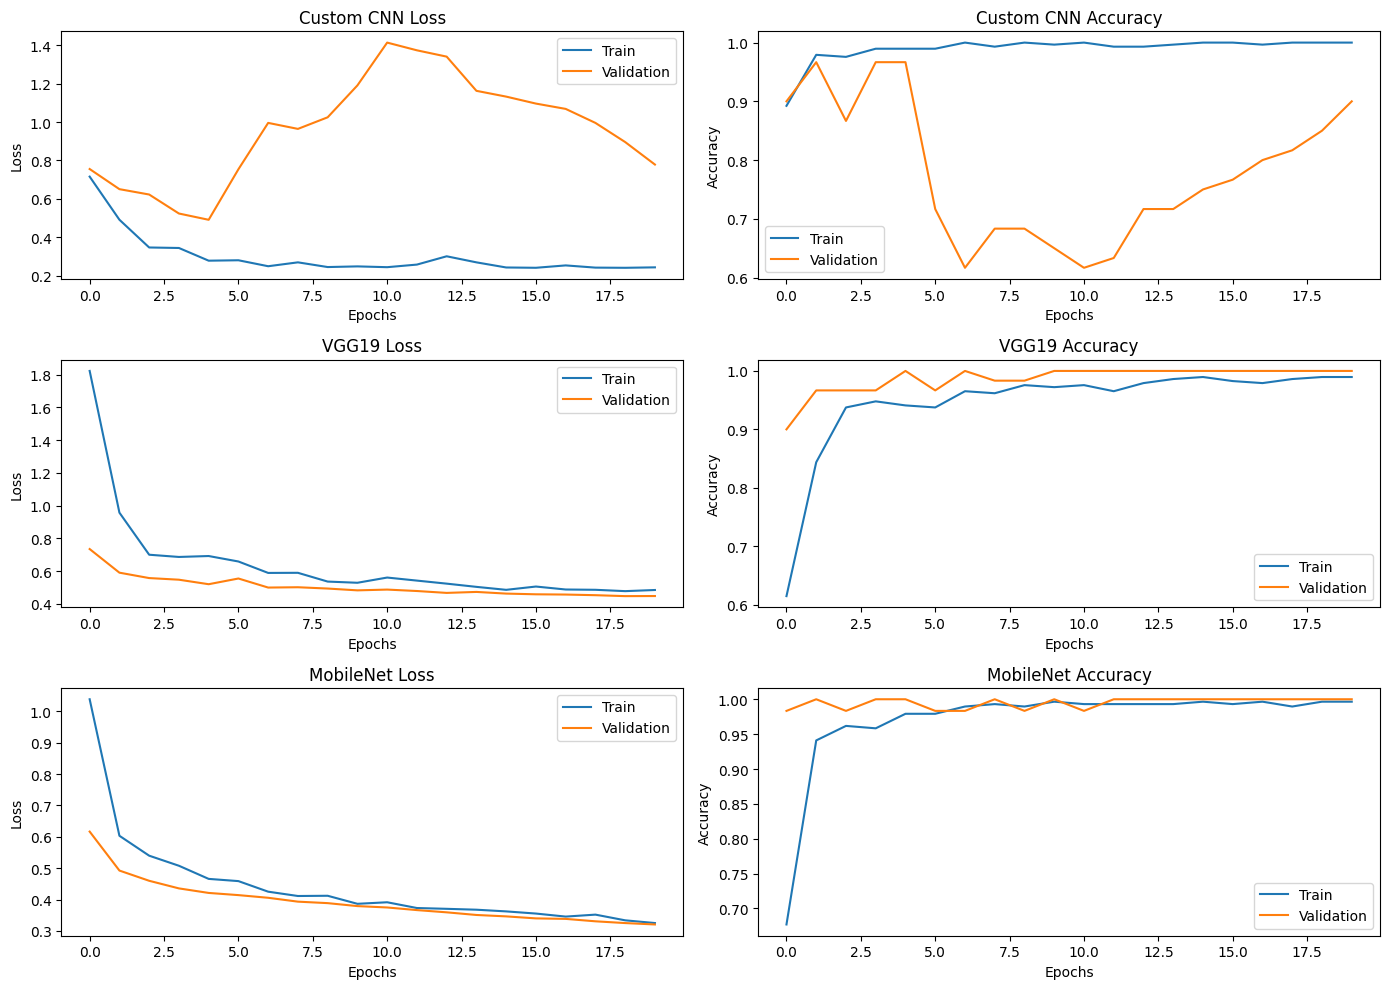

In [ ]:
# Plotting
plt.figure(figsize=(14, 10))
# Define the titles
titles = ["Custom CNN Loss", "Custom CNN Accuracy",
          "VGG19 Loss", "VGG19 Accuracy",
          "MobileNet Loss", "MobileNet Accuracy"]
# loop through the plots
for i, (train_key, val_key, title) in enumerate([
    ('loss', 'val_loss', titles[0]),
    ('accuracy', 'val_accuracy', titles[1]),
    ('loss', 'val_loss', titles[2]),
    ('accuracy', 'val_accuracy', titles[3]),
    ('loss', 'val_loss', titles[4]),
    ('accuracy', 'val_accuracy', titles[5]),
]):
    plt.subplot(3, 2, i+1)
    # plot the data
    history = [history_custom, history_custom, history_vgg19, history_vgg19, history_mob, history_mob][i]
    plt.plot(history.history[train_key], label='Train')
    plt.plot(history.history[val_key], label='Validation')
    plt.xlabel('Epochs') # Number of epochs
    plt.ylabel(train_key.capitalize()) # loss or accuracy
    plt.title(title) # title
    plt.legend() # show the legend

plt.tight_layout() # adjust the layout
plt.show() # show the plot


### TASK 1 -> Generating and Plotting Confusion Matrices for Each Model

This code generates and displays confusion matrices for the predictions made by each model (Custom CNN, VGG19, and MobileNet) on the test dataset. The matrices visualize the model's performance in terms of true positives, true negatives, false positives, and false negatives, providing insights into its classification accuracy.

Confusion Matrix for Custom CNN


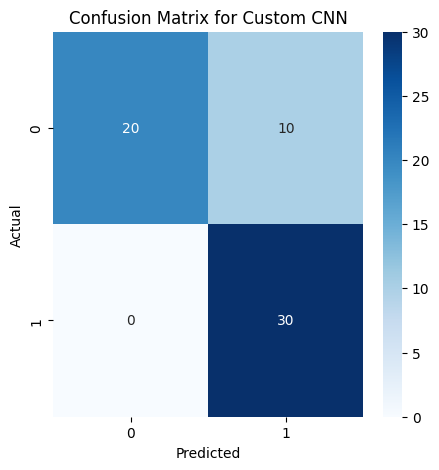

Confusion Matrix for VGG19


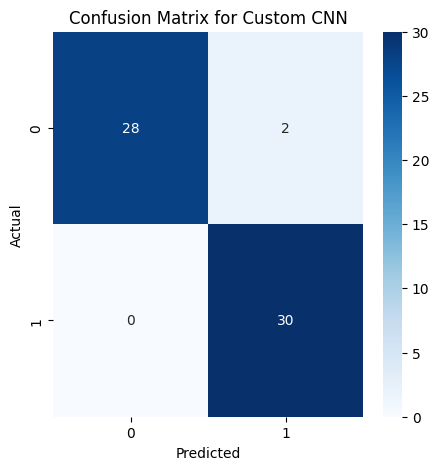

Confusion Matrix for MobileNet


In [ ]:
# make predictions based on the model
def make_predictions(model):
  # y test and y actual are empty lists
  y_test = []
  y_actual = []
  # loop through the test folder
  for subfolder in os.listdir(TEST_FOLDER):
    # loop through the files
    for file in os.listdir(os.path.join(TEST_FOLDER,subfolder)): #subfolder):
      # read the image
      img = cv2.imread(os.path.join(TEST_FOLDER,subfolder,file))
      # resize the image
      img = cv2.resize(img,(224,224))
      # convert the image to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # expand the dimensions
      img = np.expand_dims(img, axis=0)
      # predict
      p = model.predict(img, verbose=0)
      # append
      if subfolder == "NORMAL":
        y_actual.append(0)
      else:
        y_actual.append(1)
      y_test.append(1 if p[0][0] >= 0.5 else 0)
  # print the confusion matrix
  cm = confusion_matrix(y_actual, y_test)
  # plot the confusion matrix
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
  plt.xlabel("Predicted") # predicted
  plt.ylabel("Actual") # actual
  plt.title("Confusion Matrix for Custom CNN") # title
  plt.show() # show the plot

print("Confusion Matrix for Custom CNN")
# call the function with the cnn model
make_predictions(model_custom)
print("Confusion Matrix for VGG19")
# call the function with the vgg19 model
make_predictions(model_vgg19)
# call the function with the mobilenet model
print("Confusion Matrix for MobileNet")
#make_predictions(model_mob)

### TASK 2 Attempt to Improve Model Performance with a Deeper CNN Architecture

In Task 1, it was observed that VGG16 performed better compared to all three models. To further improve performance, a deeper CNN architecture was tried, incorporating additional layers, including more convolutional layers, max pooling, and dropout to prevent overfitting. The model consists of multiple convolutional layers followed by max-pooling layers and dropout layers to enhance generalization. The final dense layer is added before the output layer for binary classification.

In [46]:
# creating model
model = Sequential()
# adding convolutional layers
model.add(Conv2D(32,kernel_size=(3,3),
                 activation="relu",input_shape=(224,224,3)))
# first layer with 64 filters + pooling layer + dropout
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# second layer with 128 filters + pooling layer + dropout
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# third layer with 128 filters + pooling layer + dropout
model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# fourth layer with 128 filters + pooling layer + dropout
model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# flattening
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))
# output layer
model.add(Dense(1,activation="sigmoid"))
# compiling
model.compile(loss=keras.losses.binary_crossentropy,optimizer = "adam",metrics=["accuracy"])
# summary
model.summary()

e:\learning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,457,537 (5.56 MB)

 Trainable params: 1,457,537 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# model training with generators with augmentation, epochs = 50
hist = model.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 20,
    validation_data = test_generator, 
    validation_steps = 20)

e:\learning\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4803 - loss: 1.4188 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/20


e:\learning\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5579 - loss: 0.6920 - val_accuracy: 0.7000 - val_loss: 0.6916
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5882 - loss: 0.6822 - val_accuracy: 0.9500 - val_loss: 0.6723
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6376 - loss: 0.6392 - val_accuracy: 0.7667 - val_loss: 0.5720
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7382 - loss: 0.5262 - val_accuracy: 0.9833 - val_loss: 0.4543
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8258 - loss: 0.3798 - val_accuracy: 0.9833 - val_loss: 0.1874
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8565 - loss: 0.3895 - val_accuracy: 0.7667 - val_loss: 0.6817
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8365 - loss: 0.3986 - val_accuracy: 0.9333 - val_loss: 0.2481
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9038 - loss: 0.2805 - val_accuracy: 0.9833 - val_loss: 0.1483
Epo

#### TASK 2 -> Plotting Accuracy and Loss Curves for Model Training

This code generates two subplots to visualize the model's performance during training. The first subplot shows the accuracy and validation accuracy over epochs, while the second subplot displays the loss and validation loss. These plots provide insights into how the model is improving and whether it is overfitting or underfitting.

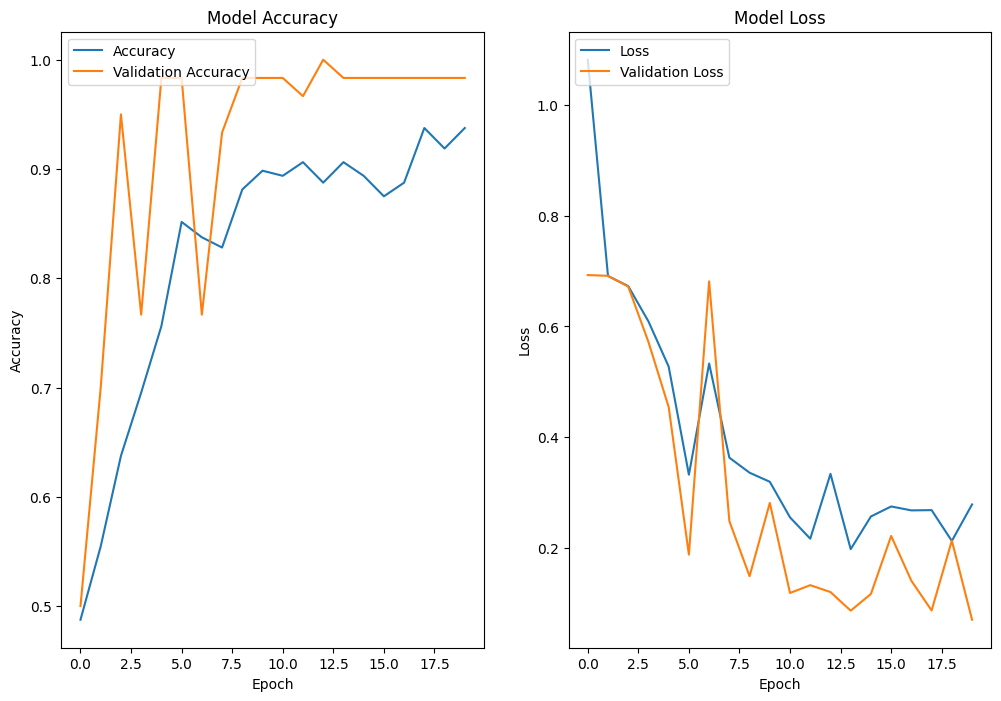

In [48]:
# plot the graphs
plt.figure(figsize=(12, 8))
# subplots
plt.subplot(1, 2, 1)
# accuracy
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"], loc="upper left")
# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"], loc="upper left")
plt.show()

In [49]:
# saving the model
model.save("model.h5")

#### TASK 2: MODEL EVALUATION

In [50]:
# model evaluation
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(test_generator)
print("Train accuracy: ", train_accuracy)
print("Validation accuracy: ", val_accuracy)
print("Train loss: ", train_loss)
print("Validation loss: ", val_loss)

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 506ms/step - accuracy: 0.9561 - loss: 0.1564
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.9829 - loss: 0.0687
Train accuracy:  0.9513888955116272
Validation accuracy:  0.9833333492279053
Train loss:  0.1551559716463089
Validation loss:  0.0696801170706749


#### TASK 2-> Loading the Trained Model and Making Predictions

The trained model is loaded from the "model.h5" file, and predictions are made on the test dataset. For each image in the test folder, the image is preprocessed, passed through the model, and a prediction is made. The true labels (y_actual) and predicted labels (y_test) are stored for evaluating model performance.

In [ ]:
# load model
model = load_model("model.h5")
# make predictions
y_test = []
y_actual = []

def make_predictions():
  # loop through the test folder
  for subfolder in os.listdir(TEST_FOLDER):
    # loop through the files
    for file in os.listdir(os.path.join(TEST_FOLDER,subfolder)): #subfolder):
      # read the image
      img = cv2.imread(os.path.join(TEST_FOLDER,subfolder,file))  #subfolder+"/"+file)
      # resize the image
      img = cv2.resize(img,(224,224))
      # convert the image to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # expand the dimensions
      img = np.expand_dims(img,axis=0)
      # predict
      p = model.predict(img, verbose=0)
      # append
      y_test.append(1 if p[0][0] >= 0.5 else 0)
      if subfolder == "NORMAL":
        y_actual.append(0)
      else:
        y_actual.append(1)
# call the function
make_predictions()


#### TASK 2 -> Confusion Matrix

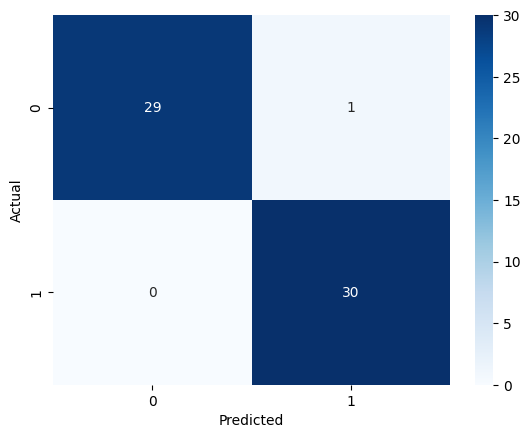

In [ ]:
# confusion matrix
sns.heatmap(confusion_matrix(y_actual, y_test), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted") # predicted
plt.ylabel("Actual") # actual
plt.show() # show the plot


#### TASK 2 -> Visualizing Model Predictions on Validation Images

The code visualizes the model's predictions by displaying random images from the validation set along with their actual and predicted labels.

For each image, the actual label (Normal or Covid) and the predicted label are overlaid on the image. 

The model’s performance is assessed by comparing the actual and predicted labels visually for both normal and covid images from the validation folder.

['NORMAL2-IM-0373-0001.jpeg' 'NORMAL2-IM-0374-0001.jpeg'
 'NORMAL2-IM-0372-0001.jpeg'] ['SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg'
 'ryct.2020200034.fig2.jpeg'
 'SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg']


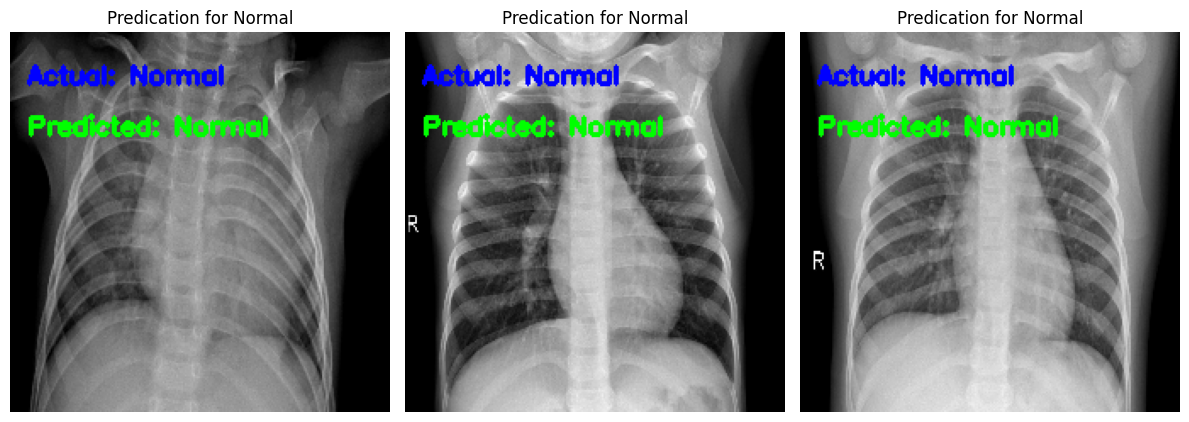

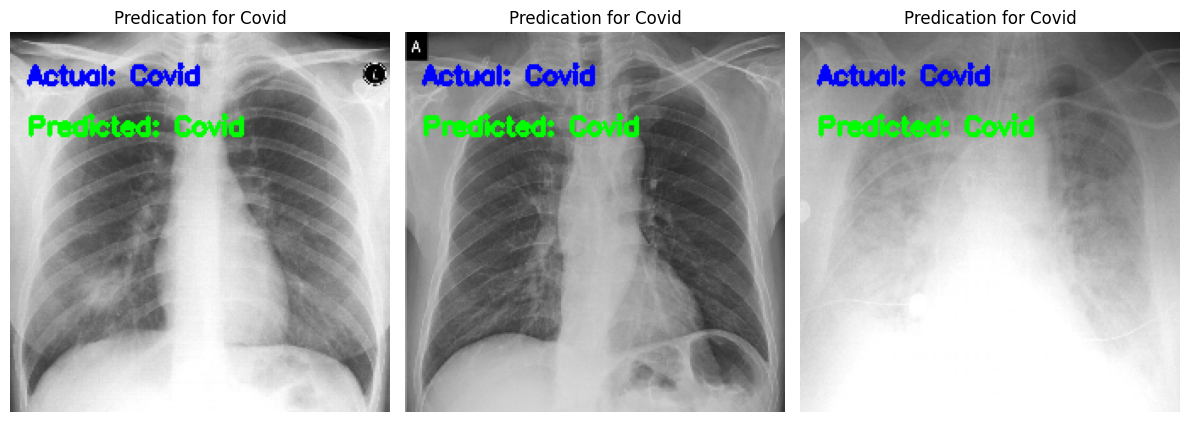

In [53]:
def view_output(images, subfolder):
    plt.figure(figsize=(12, 8))
    for indx,img in enumerate(images):
        actual = "Normal" if subfolder == "NORMAL" else "Covid"
        img = cv2.imread(os.path.join(VAL_FOLDER,subfolder,img))
        img = cv2.resize(img,(224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        np_img = np.expand_dims(img,axis=0)
        p = model.predict(np_img, verbose=0)
        if p[0][0] >= 0.5:
          predicted = "Covid"
        else:
          predicted = "Normal"
        
        cv2.putText(img, f"Actual: {actual}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.putText(img, f"Predicted: {predicted}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        plt.subplot(1, 3, indx + 1)
        plt.imshow(img)
        plt.title(f"Predication for {actual}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
        
# make predictions on test data
normal_images = [f for f in os.listdir(os.path.join(VAL_FOLDER, "NORMAL"))]
covid_images = [f for f in os.listdir(os.path.join(VAL_FOLDER, "PNEUMONIA"))]
random_3_images = np.random.choice(normal_images, 3, replace=False)
random_3_covid_images = np.random.choice(covid_images, 3, replace=False)
print(random_3_images,random_3_covid_images)

view_output(random_3_images, "NORMAL")
view_output(random_3_covid_images, "PNEUMONIA")
